# Change Point Selection
In this notebook, we compare multivariate ClaSP with change point selection.

In [14]:
# needed for PDF/A
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [15]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

from aeon.visualisation import plot_critical_difference
from external.MCM import MCM
from wand.image import Image

sns.set_theme()
sns.set_color_codes()

import os
import sys

sys.path.append("../../")

Let's choose a score for evaluation (F1 or Covering).

In [16]:
eval_score = "covering_score"

Let's load the scores from the different methods.

In [17]:
competitors = ["CPClustering", "CPWeighting", "CPPruning"]
datasets = ["HAS_train"] #    

methods, dfs = list(), list()

for candidate_name in competitors:
    methods.append((candidate_name, f"{candidate_name}.csv.gz"))

for idx, (name, file_name) in enumerate(methods):
    df = []
    
    for d in datasets:
        df.append(pd.read_csv(f"../experiments/ablation_study/{d}_{file_name}", usecols=["dataset", eval_score], compression="gzip"))
    
    df = pd.concat(df)
    df.sort_values(by="dataset", inplace=True)
    dfs.append((name, df))

df_scores = pd.DataFrame()

for name, df in dfs:
    df_scores["dataset"] = df.dataset
    df_scores[name] = df[eval_score]

df_scores.reset_index(drop=True, inplace=True)
df_scores

,dataset,CPClustering,CPWeighting,CPPruning
0,indoor_subject1_routine1 (id140),0.498,0.500,0.433
1,indoor_subject1_routine1 (id93),0.800,0.225,0.511
2,indoor_subject1_routine1 (id150),0.637,0.800,0.791
3,indoor_subject3_routine3 (id186),0.218,0.822,0.962
4,indoor_subject3_routine3 (id19),0.669,0.880,0.867
5,indoor_subject4_routine3 (id215),0.696,0.761,0.770
6,indoor_subject1_routine2 (id127),0.576,0.218,0.218
7,indoor_subject2_routine1 (id176),0.400,0.680,0.506
8,indoor_subject1_routine2 (id177),0.377,0.747,0.843
9,indoor_subject1_routine3 (id180),0.158,0.624,0.576


Let's calculate the mean/median/std score.

In [18]:
df_scores.iloc[:,1:].mean(axis=0).sort_values(ascending=False).round(3)

CPWeighting     0.713
CPPruning       0.706
CPClustering    0.696
dtype: float64

In [19]:
df_scores.iloc[:,1:].median(axis=0).sort_values(ascending=False).round(3)

CPWeighting     0.743
CPPruning       0.711
CPClustering    0.703
dtype: float64

In [20]:
df_scores.iloc[:,1:].std(axis=0).sort_values().round(3)

CPPruning       0.211
CPWeighting     0.229
CPClustering    0.245
dtype: float64

Let's compute the wins per method.

In [21]:
ranks = df_scores.iloc[:,1:].rank(1, method='min', ascending=False)
means = np.array(ranks.mean(axis=0))
args = np.argsort(means)

In [22]:
for mean, name in zip(means[args], df_scores.columns[1:].to_numpy()[args]):
    print(f"{name}:wins={ranks[ranks[name] == 1].shape[0]} rank={np.round(mean, 1)}")

CPWeighting:wins=54 rank=1.8
CPPruning:wins=40 rank=1.9
CPClustering:wins=53 rank=2.0


Let's plot the CD diagram.

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_4619/3244683330.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../figures/cd_segmentation_cp_selection.pdf", bbox_inches="tight")
/Users/ermshaua/miniconda3/envs/mclasp/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


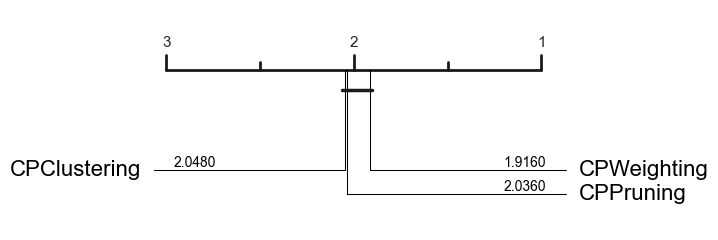

In [23]:
ax = plot_critical_difference(
    scores=df_scores.iloc[:, 1:].to_numpy(),
    labels=df_scores.columns[1:].to_numpy(),
    correction="holm",
    alpha=0.05,
)

plt.savefig("../figures/cd_segmentation_cp_selection.pdf", bbox_inches="tight")

 Let's plot the MCM.

Processing CPPruning, CPWeighting:   0%|          | 0/3 [00:00<?, ?it/s]   


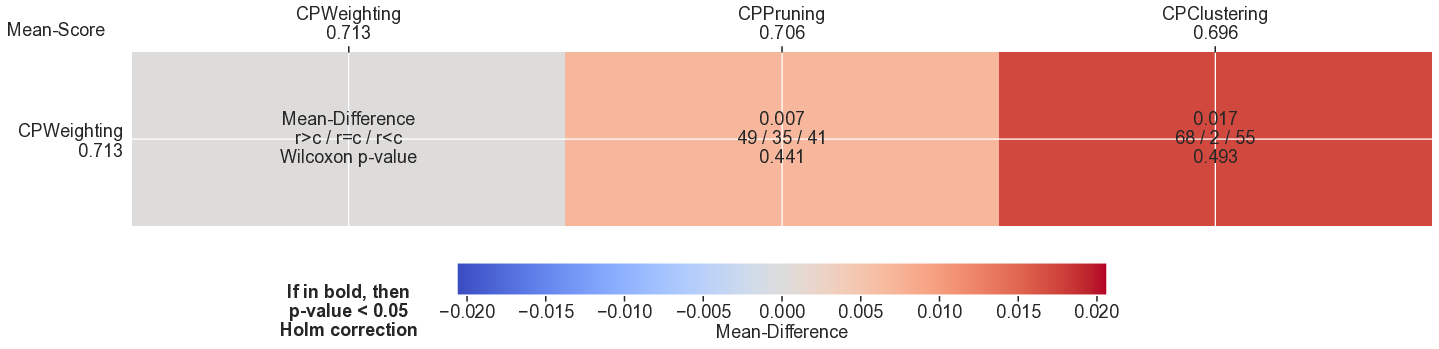

In [24]:
dir_path = "../figures/"
file_name = "mcm_segmentation_cp_selection"

MCM.compare(
    output_dir=dir_path,
    used_statistic="Score",
    save_as_json=False,
    df_results=df_scores.iloc[:, 1:],
    pdf_savename=file_name,
    load_analysis=False,
    pvalue_correction="Holm",
    row_comparates=("CPWeighting",),
    fig_size=(20,5),
    font_size=18,
    precision=3
)
Image(filename=os.path.join(dir_path, file_name + ".pdf"))

Let's compute wins/losses against CPWeighting.

In [25]:
selection = "CPWeighting"

for rival in df_scores.columns[1:]:
    if rival == selection: continue

    df_pair = df_scores[[selection, rival]]
    pair_ranks = df_pair.rank(1, method='min', ascending=False)

    wins = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 2)].shape[0]
    losses = pair_ranks[(pair_ranks[selection] == 2) & (pair_ranks[rival] == 1)].shape[0]
    ties = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 1)].shape[0]

    assert wins + losses + ties == pair_ranks.shape[0]

    print(f"{selection} vs {rival}: (wins/ties/losses): {wins}/{ties}/{losses}")

CPWeighting vs CPClustering: (wins/ties/losses): 68/2/55
CPWeighting vs CPPruning: (wins/ties/losses): 49/35/41


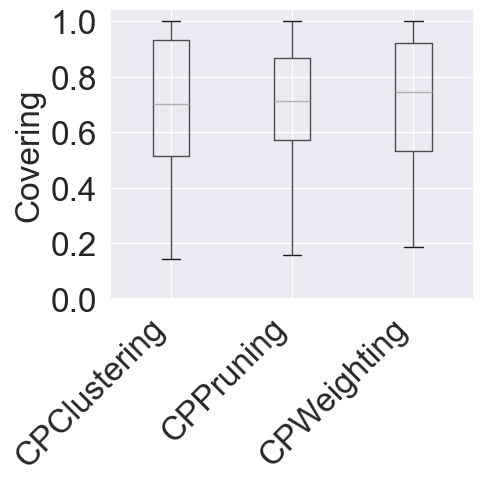

In [26]:
fontsize = 24
_, ax = plt.subplots(figsize=(5, 5))

# sort by median performance
df_sorted_scores = df_scores[df_scores.iloc[:, 1:].median(axis=0).sort_values().index]

df_sorted_scores.boxplot(ax=ax, rot=90)
ax.set_ylabel("Covering", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xticklabels(df_sorted_scores.columns, rotation=45, ha="right")
ax.set_yticks(np.round(np.arange(0, 1.0 + .2, .2), 1))

plt.savefig(f"../figures/bp_segmentation_cp_selection.pdf", bbox_inches="tight")